In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import random
import tensorflow as tf
%matplotlib inline

In [2]:
# All the pictures in prediction folder are pictures I cut from Google Street View in Manhattan, New York. 
# The numbers are from various places like car, bus, advertisement, house number, street slogan and so on.
# All 17 pictures are already resized to 32 x 32 pixels.

# Get all the images for prediction
prediction_folder = '/prediction/'
image_files = os.listdir(os.getcwd() +  prediction_folder)

image_size = 32
num_channels = 3
num_labels = 11

data_orign = np.ndarray(shape=(len(image_files), image_size, image_size, num_channels), dtype=np.float32)

# Assign correct labels to each picture
label = [2, 5, 3, 25, 7, 5, 27, 25, 8, 10, 3, 2, 2, 8, 55, 26, 3]

for image in image_files:
    image_file = str(os.getcwd() + os.path.join(prediction_folder, image))
    try:
        img = Image.open(image_file).convert("RGB")
        image_data = np.array(img)
        index = int(image.split('.')[0])
        data_orign[index, :, :,:] = image_data

    except IOError as e:
        print(e)

cannot identify image file '/Users/Hongwei/Desktop/housenumbers/prediction/.DS_Store'


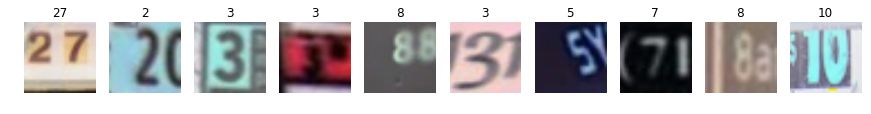

In [4]:
#Display original pictures

plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(random.sample(range(0, 17), 10)):  
    ax[i].axis('off')
    ax[i].set_title(label[j], loc='center')
    ax[i].imshow(data_orign[j,:,:,:])

In [5]:
#1. Turn RGB to gray

#Refer to Matlab's rgb2gray algorithm https://www.mathworks.com/help/matlab/ref/rgb2gray.html
#rgb2gray converts RGB values to grayscale values by forming a weighted sum of the R, G, and B components:
#0.2989 * R + 0.5870 * G + 0.1140 * B 

def rgb2gray(image):
    return np.dot(image.astype(float), [[0.2989],[0.5870],[0.1140]])

# 0 means and Normalization
def mean_normal(image):
    image_dim = image.shape[0]
    image_norm = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(image_dim):
        std = np.std(image[i,:,:])
        if std < 1e-4:
            std = 1e-4 
        image_norm[i,:,:] = (image[i,:,:] - image[i,:,:].mean())/std
    return image_norm

In [6]:
# Normalize pictures
data_norm = mean_normal(rgb2gray(data_orign))

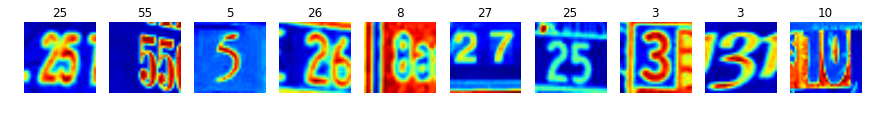

In [7]:
# Display normalized data
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(random.sample(range(0, 17), 10)):  
    ax[i].axis('off')
    ax[i].set_title(label[j], loc='center')
    ax[i].imshow(data_norm[j,:,:,0])


In [8]:
# Build the CNN model

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
output1 = 64
output2 = 32
num_channels = 1
beta = 0.01 # beta parameter for L2 loss


graph = tf.Graph()

with graph.as_default():
    
    # Input data.
    pred_data = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)
    
    def bias_variable(shape, init):
        initial = tf.constant(init, shape=shape)
        return tf.Variable(initial)
    
    def conv2d(x, W, padding):
        # stride [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = padding)
    
    def max_pool_2x2(x):
        # stride [1, x_movement, y_movement, 1]
        return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    
    #Layer variables:
    
    # conv layer 1
    conv1_W = weight_variable([patch_size, patch_size, num_channels, depth1]) # [5, 5, 1, 16]
    conv1_b = bias_variable([1, depth1], 0.1)
    
    # conv layer 2
    conv2_W = weight_variable([patch_size, patch_size, depth1, depth2]) #[5, 5, 16, 32]
    conv2_b = bias_variable([1, depth2], 1.0)
    
    # conv layer 3
    conv3_W = weight_variable([patch_size, patch_size, depth2, depth3]) #[5, 5, 32, 64]
    conv3_b = bias_variable([1, depth3], 1.0)
    
    # fc layer 1
    fc1_W = weight_variable([output1, output2]) # 64, 32
    fc1_b = bias_variable([1, output2], 1.0)
    
    # fc layer 2
    fc2_W = weight_variable([output2, num_labels])
    fc2_b = bias_variable([1, num_labels], 1.0) # 32, 11
    
    def model(data, keep_prob):  
        
        # conv layer 1
        conv1_h = tf.nn.relu(conv2d(data, conv1_W, 'VALID') + conv1_b) # 28 * 28* 16
        # Local Response Normalization
        norm1 = tf.nn.local_response_normalization(conv1_h)
        # Max Pooling 1
        pool1 = max_pool_2x2(norm1) # 14 * 14 * 16
        
        # conv layer 2
        conv2_h = tf.nn.relu(conv2d(pool1, conv2_W, 'VALID') + conv2_b) # 10 * 10 * 32
        # Local Response Normalization
        norm2 = tf.nn.local_response_normalization(conv2_h)
        #Max Pooling 2
        pool2 = max_pool_2x2(norm2) # 5 * 5 * 32
        
        # conv layer 3
        conv3_h = tf.nn.relu(conv2d(pool2, conv3_W, 'VALID') + conv3_b) # 1 * 1 * 64
        # Drop out
        conv3_drop = tf.nn.dropout(conv3_h, keep_prob)
        
        # fc layer 1
        pool2_flat = tf.reshape(conv3_drop, [-1, 1 * 1 * 64]) # reshape pooled picture
        fc1_h = tf.nn.relu(tf.matmul(pool2_flat, fc1_W) + fc1_b) # 64, 32
        
        # fc layer 2
        fc2_h = tf.matmul(fc1_h, fc2_W) + fc2_b # 32, 11
        
        return fc2_h
  
    
    # Predictions
    pred = tf.nn.softmax(model(pred_data, 1.0))
    pred_result = tf.transpose(tf.argmax(pred, 1))
    saver = tf.train.Saver()


In [9]:
# Use trained CNN weights to predict new pictures
with tf.Session(graph=graph) as session:
    saver.restore(session, "SVHN_weight.ckpt")
    feed_dic = {pred_data : data_norm}
    prediction = session.run(pred_result, feed_dict = feed_dic)

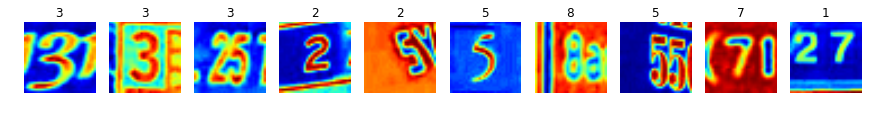

In [11]:
# Display normalized data
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(random.sample(range(0, 17), 10)):  
    ax[i].axis('off')
    ax[i].set_title(prediction[j], loc='center')
    ax[i].imshow(data_orign[j,:,:,0])